# Performance Indicators

## Set Up

In [1]:
import folium
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (15.0, 9.5)

In [2]:
%run src/data/helper.py

In [3]:
%run src/data/periods.py

In [4]:
%run src/data/visualization.py

In [5]:
import pickle

readings = pickle.load(open("data/parsed/readings_weather_filled_dataset.p", "rb"))
stations = pickle.load(open('data/parsed/stations_dataset_final.p', 'rb'))

KeyboardInterrupt: 

In [ ]:
readings = readings[readings.Source == 'REAL']
readings.drop('Source', axis=1, inplace=True)

In [ ]:
stations.Priority = stations.Priority.fillna(3).astype('int8')

## Timezone

The readings are in the UTC timezone so we'll change them to the Europe/London timezone.

In [ ]:
from pytz import timezone

start_time = time.time()

readings['Timestamp'] = readings.Timestamp.dt.tz_convert(timezone('Europe/London'))
readings['Timestamp'] = readings.Timestamp.dt.tz_localize(None)

end_time = time.time()
print 'Modifying timestamp took %s' % (end_time - start_time)

## Introduction

The Service Level Agreement (SLA) signed by TfL and Serco outlines 34 performance indicators (PI) to measure the quality of the provided service. In this research we focused on the PIs that are related to bicycle distribution, PIs 24, 25, 26 and 27. These PIs take into account the following distinctions of time and stations:

* **Station Priority**: Each docking station was classified as **Priority 1 or Priority 2** based on it's importance for the overall operation of the London Cycle Hire Scheme. Highly used docking stations were given the Priority 1 classification, while the remaining stations were classified as Priority 2.
* ** Peak Hours**: The hours during which crowding on the public transportation system and the traffic on roads are  the highest are called **Peak Hours**. The SLA defines them to be from 7:00 to 10:00 and 16:00 to 19:00, all the other times are considered non-peak hours.

The number of minutes for which each docking station is full or empty over a calendar day shall be accumulated, respectively. Then, these empty or full periods will be summed and grouped by priority and peak/non-peak hours to assess the goodness of the bicycle distribution according to the following criteria:

|Classification|Time|Acceptable Service Level|
|-----|------|------|
|Priority 1|Peak Hours|Less than 1000 minutes for all stations per peak period |
|Priority 1|Non-Peak Hours|Less than 3000 minutes for all stations|
|Priority 2|Peak Hours|Less than 9000 minutes for all stations per peak period |
|Priority 2|Non-Peak Hours|Less than 18000 minutes for all stations|


**Note: These acceptable service levels were taken from the original LONDON CYCLE HIRE SERVICE AGREEMENT published in 2009 when there were only 352 docking stations.**

Other operational PIs measure the number of continuous minutes that a priority 1 station is full or empty during peak hours.

We will focus on these criteria to measure the performance of the bicycle hire system from 16/05/2016 to 26/06/2016.

## Empty and Full Stations PIs

A docking docking station with no fully functional bicycles is considered to be **empty**. One or more biycles marked for repair can be present in an empty docking station. 

In [ ]:
readings.sort_values(by=['Id', 'Timestamp'], inplace=True)

In [ ]:
empty_entries = find_zero_periods(readings, 'NbBikes')
empty_groups = get_ellapsed_time(empty_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

In [ ]:
full_entries = find_zero_periods(readings, 'NbEmptyDocks')
full_groups = get_ellapsed_time(full_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

The data was processed to compute the periods during which the stations were empty. The following dataframe shows this information.

In [ ]:
empty_groups[['Id','Period','Ellapsed']].head()

In [ ]:
full_groups[['Id','Period','Ellapsed']].head()

The data shows that several stations were empty or full during entire days. It is very unlikely that these stations did not have any hire activity during these time periods as the stations had fairly regular activity before and after. Therefore, we'll assume that these empty periods were caused by malfunctions in the stations or in the data collection process and should be discarded. 

In order to remove this erroneous readings, we will delete any empty or full periods of more than or equal to 720 minutes (12 hours). This number is what we consider the worst case scenario for a naturally inactive station. It was computed by taking into account the 10 hours restriction placed by some boroughs that forbids the service provider to redistribute bicycles between 22:00 and 8:00 and the 2 hours that might be needed for the redistribution to take place.

In [ ]:
invalid_threshold = 720

invalid_group_ids = empty_groups[empty_groups.Ellapsed >= invalid_threshold].GroupId
empty_entries = empty_entries[~empty_entries.GroupId.isin(invalid_group_ids)]

invalid_group_ids = full_groups[full_groups.Ellapsed >= invalid_threshold].GroupId
full_entries = full_entries[~full_entries.GroupId.isin(invalid_group_ids)]

The periods were further divided by day, morning peak hours, evening, peak hours, and non-peak hours.

In [ ]:
empty_periods = get_ellapsed_time(empty_entries, by='PeriodId')
empty_periods = add_station_info(empty_periods, stations, ['Priority', 'Id'])
empty_periods['Day'] = empty_periods['Period'].apply(lambda x: get_period_day(x))
empty_periods['PeakHours'] = empty_periods['Period'].apply(lambda x: is_peaktime(x)[1])

full_periods = get_ellapsed_time(full_entries, by='PeriodId')
full_periods = add_station_info(full_periods, stations, ['Priority', 'Id'])
full_periods['Day'] = full_periods['Period'].apply(lambda x: get_period_day(x))
full_periods['PeakHours'] = full_periods['Period'].apply(lambda x: is_peaktime(x)[1])

#### Accumulated Empty Minutes per Station

In [ ]:
empty_stations = empty_periods.groupby(['Id', 'Priority']).sum().sort_values(by=['Ellapsed'], ascending=False)
empty_stations = add_station_info(empty_stations.reset_index(level=0), stations, cols=['Id', 'Name', 'Priority', 
                                                                                  'Latitude', 'Longitude'])

Here is the list of the top 20 stations that were the most empty.  

In [ ]:
empty_stations.head(20)

In [ ]:
normalizer = matplotlib.colors.Normalize(vmin=min(empty_stations.Ellapsed) - 0.1,vmax=max(empty_stations.Ellapsed) + 0.1)
empty_stations['EllapsedN'] = empty_stations.Ellapsed.apply(normalizer)

The following map plots the 100 stations that accumulated the most empty minutes. Dark fill colors indicate more empty minutes.

In [ ]:
from palettable.colorbrewer.sequential import OrRd_9
from palettable.colorbrewer.diverging import RdYlBu_10_r

def accumulated_minutes_marker(station):
    line_color = map_priority_color(station['Priority'])[1]
    fill_color = cmap_to_hex(plt.get_cmap('seismic'), station.EllapsedN) 
    label = "%s - %s" % (station['Id'], station['Name'])
    
    return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=75,
                        popup=label, fill_color=fill_color, color=fill_color, fill_opacity=0.9)

In [116]:
empty_stations_map = draw_stations_map(empty_stations.sort_values(by=['Ellapsed']), accumulated_minutes_marker)
folium.Map.save(empty_stations_map, 'reports/maps/empty_stations_map.html')
empty_stations_map

In [47]:
empty_entries_by_day = find_zero_periods(readings, 'NbBikes', split_by_day)
empty_groups_by_day = get_ellapsed_time(empty_entries_by_day, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

invalid_group_ids_by_day = empty_groups_by_day[empty_groups_by_day.Ellapsed >= invalid_threshold].GroupId
valid_empty_entries_by_day = empty_entries_by_day[~empty_entries_by_day.GroupId.isin(invalid_group_ids_by_day)]

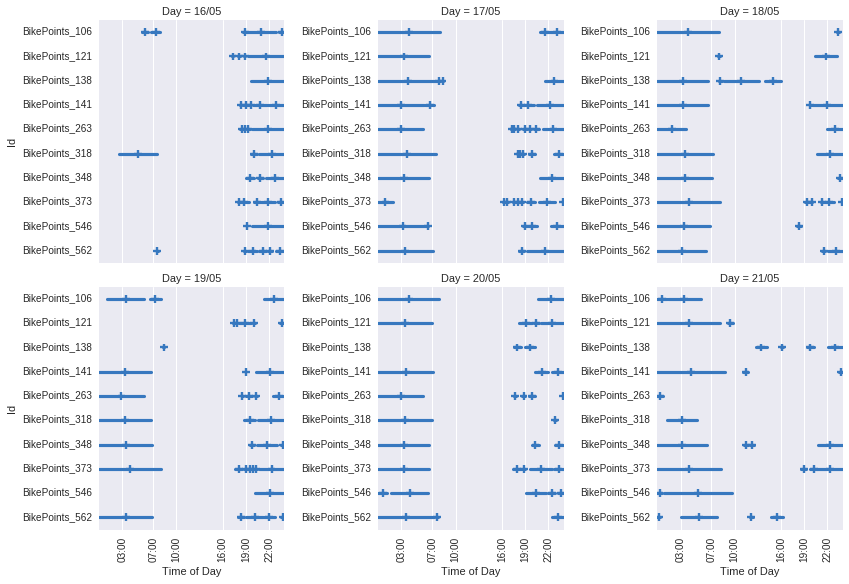

In [48]:
plot_periods(valid_empty_entries_by_day, datetime(2016, 5, 16), datetime(2016, 5, 21, 23, 59, 59, 999999), empty_stations.Id[0:10])
plt.savefig('reports/images/empty_stations_periods.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

#### Accumulated Full Minutes per Station

In [50]:
full_stations = full_periods.groupby(['Id', 'Priority']).sum().sort_values(by=['Ellapsed'], ascending=False)
full_stations = add_station_info(full_stations.reset_index(level=0), stations, cols=['Id', 'Name', 'Priority', 
                                                                                  'Latitude', 'Longitude'])

Here is the list of the top 10 stations that were the most full.  

In [51]:
full_stations.head(20)

,Id,Ellapsed,Name,Latitude,Longitude,Priority
0,BikePoints_818,19942.0,"One Tower Bridge, Southwark",51.503127,-0.078655,3
1,BikePoints_224,17260.0,"Whiteleys, Bayswater",51.514769,-0.188129,2
2,BikePoints_185,14644.0,"Alderney Street, Pimlico",51.488057,-0.140741,2
3,BikePoints_290,14303.0,"Winsland Street, Paddington",51.516780,-0.175488,2
4,BikePoints_782,13528.0,"Halford Road, West Kensington",51.483911,-0.197609,3
5,BikePoints_777,13361.0,"Limburg Road, Clapham Junction",51.461923,-0.165297,2
6,BikePoints_255,13194.0,"Clifton Road, Maida Vale",51.525575,-0.179592,2
7,BikePoints_302,12174.0,"Putney Pier, Wandsworth",51.466907,-0.216573,2
8,BikePoints_527,12098.0,"Hansard Mews, Holland Park",51.503802,-0.215808,2
9,BikePoints_451,11972.0,"Hermitage Court, Wapping",51.504719,-0.063531,2


In [52]:
normalizer = matplotlib.colors.Normalize(vmin=min(full_stations.Ellapsed) - 0.1,vmax=max(full_stations.Ellapsed) + 0.1)
full_stations['EllapsedN'] = full_stations.Ellapsed.apply(normalizer)

In [117]:
full_stations_map = draw_stations_map(full_stations, accumulated_minutes_marker)
folium.Map.save(full_stations_map, 'reports/maps/full_stations_map.html')
full_stations_map

In [63]:
full_entries_by_day = find_zero_periods(readings, 'NbEmptyDocks', split_by_day)
full_groups_by_day = get_ellapsed_time(full_entries_by_day, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

invalid_group_ids_by_day = full_groups_by_day[full_groups_by_day.Ellapsed >= invalid_threshold].GroupId
valid_full_entries_by_day = full_entries_by_day[~full_entries_by_day.GroupId.isin(invalid_group_ids_by_day)]

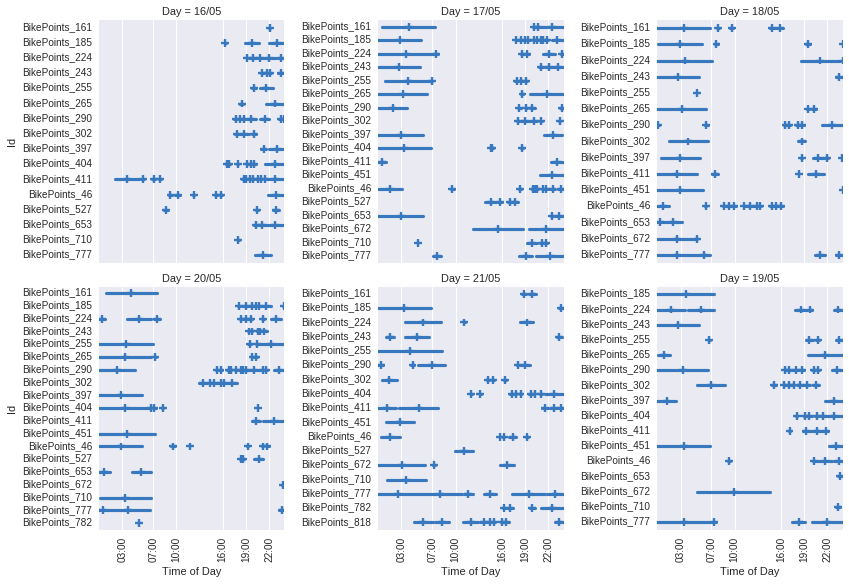

In [64]:
plot_periods(valid_full_entries_by_day, datetime(2016, 5, 16), datetime(2016, 5, 21, 23, 59, 59, 999999), full_stations.Id[0:20])
plt.savefig('reports/images/full_stations_periods.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

### PI 24 and 25 - Accumulated Empty or Full Time

In [76]:
empty_periods = empty_periods[empty_periods.Day != datetime(2016, 6, 27)]
full_periods = full_periods[full_periods.Day != datetime(2016, 6, 27)]

In [77]:
pi24_results = empty_periods.groupby(['Day', 'Priority', 'PeakHours']).sum().loc[:date(2016, 6, 26)]
pi25_results = full_periods.groupby(['Day', 'Priority', 'PeakHours']).sum().loc[:date(2016, 6, 26)]

#### Priority 1 and Priority 2 Stations	Non-Peak Hours

In [78]:
p1_non_peak_threshold = 3000
p2_non_peak_threshold = 40000

In [79]:
empty_p1_non_peak = pi24_results.xs((1.0, 'NON_PEAK'), level=('Priority', 'PeakHours'))
empty_p2_non_peak = pi24_results.xs((2.0, 'NON_PEAK'), level=('Priority', 'PeakHours'))

full_p1_non_peak = pi25_results.xs((1.0, 'NON_PEAK'), level=('Priority', 'PeakHours'))
full_p2_non_peak = pi25_results.xs((2.0, 'NON_PEAK'), level=('Priority', 'PeakHours'))

In [80]:
non_peak = pd.concat([full_p1_non_peak, empty_p1_non_peak, full_p2_non_peak, empty_p2_non_peak], axis=1)
non_peak.columns = ['P1Full', 'P1Empty', 'P2Full', 'P2Empty']

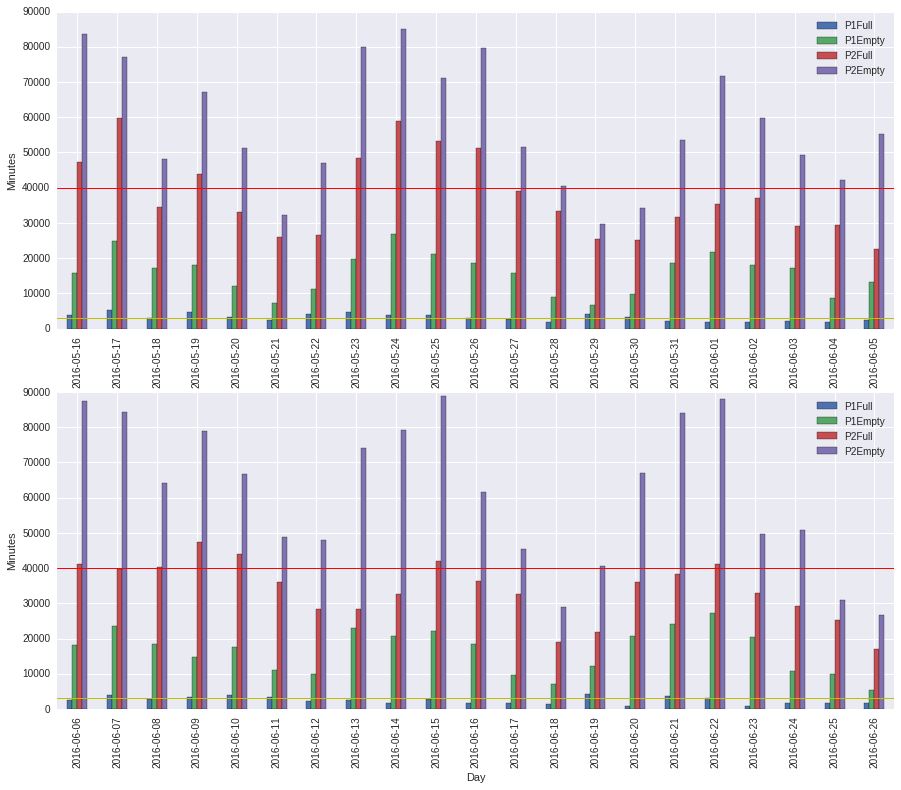

In [81]:
split_idx = len(non_peak) / 2
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15.0,12.5))  

ax = non_peak[:split_idx].plot(kind='bar', ax=axes[0])
ax.axhline(y=p1_non_peak_threshold, linewidth=1, color='y')
ax.axhline(y=p2_non_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')

ax = non_peak[split_idx:].plot(kind='bar', ax=axes[1])
ax.axhline(y=p1_non_peak_threshold, linewidth=1, color='y')
ax.axhline(y=p2_non_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')

Percentage of days failing to meet the acceptable service levels during non-peak times for priority 1 docking stations:

In [82]:
failure = pd.concat([full_p1_non_peak >= p1_non_peak_threshold, 
                      empty_p1_non_peak >= p1_non_peak_threshold, 
                      full_p2_non_peak >= p2_non_peak_threshold, 
                      empty_p2_non_peak >= p2_non_peak_threshold], axis=1)

failure.columns = ['P1Full', 'P1Empty', 'P2Full', 'P2Empty']

failure.stack().groupby(level=1).aggregate(lambda x: list(x)).apply(lambda x: (float(x.count(True)) / len(x)) * 100)

P1Empty    100.000000
P1Full      42.857143
P2Empty     85.714286
P2Full      30.952381
dtype: float64

The Figure illustrates the accumulated number of minutes during which the stations were empty or full during non-peak hours. It can be observed  that keeping stations from becoming empty during non-peak hours is particularly problematic for the service operator, with the expected operational levels not being met 100 \% and 85.71 \% of the times for P1 and P2 stations, respectively. 

#### Priority 1	Peak Hours

In [83]:
p1_peak_threshold = 1000

In [84]:
empty_p1_evening_peak = pi24_results.xs((1.0, 'EVENING_PEAK'), level=('Priority', 'PeakHours'))
empty_p1_morning_peak = pi24_results.xs((1.0, 'MORNING_PEAK'), level=('Priority', 'PeakHours'))

full_p1_evening_peak = pi25_results.xs((1.0, 'EVENING_PEAK'), level=('Priority', 'PeakHours'))
full_p1_morning_peak = pi25_results.xs((1.0, 'MORNING_PEAK'), level=('Priority', 'PeakHours'))

In [85]:
p1_peak = pd.concat([empty_p1_morning_peak, empty_p1_evening_peak, full_p1_morning_peak, full_p1_evening_peak], axis=1)
p1_peak.columns = ['EmptyMorningPeak', 'EmptyEveningPeak', 'FullMorningPeak', 'FullEveningPeak']

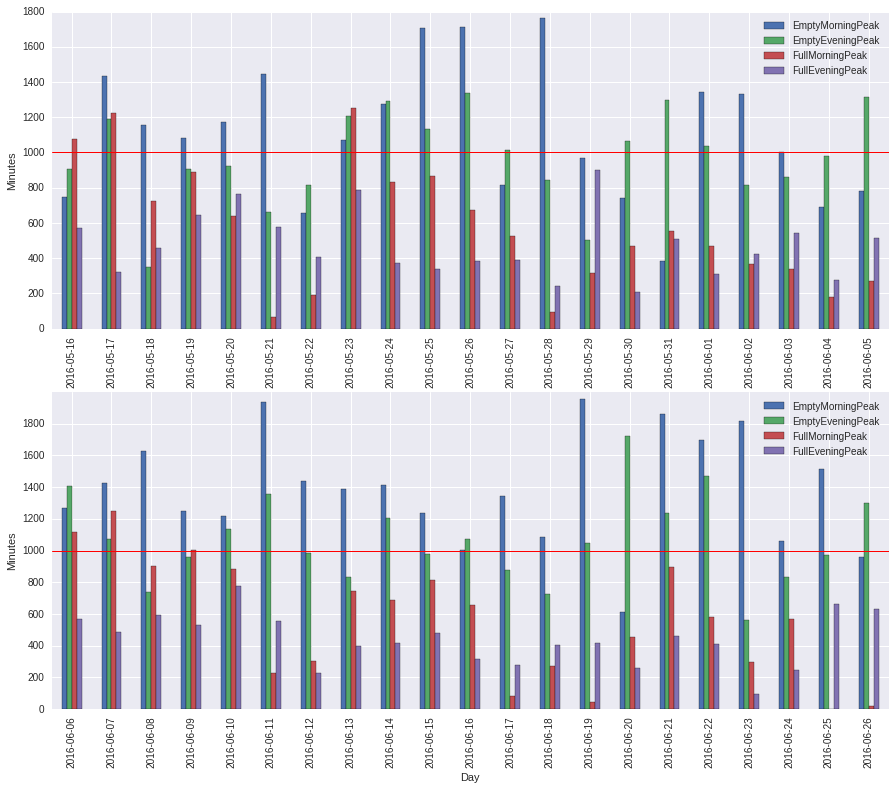

In [86]:
split_idx = len(p1_peak) / 2
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15.0,12.5))  

ax = p1_peak[:split_idx].plot(kind='bar', ax=axes[0])
ax.axhline(y=p1_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')
yticks = ax.get_yticks()

ax = p1_peak[split_idx:].plot(kind='bar', ax=axes[1])
ax.axhline(y=p1_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')
ax.set_yticks(yticks)

Percentage of days failing to meet the acceptable service levels during peak times for priority 1 docking stations:

In [87]:
failure = pd.concat([empty_p1_morning_peak >= p1_peak_threshold, 
                      empty_p1_evening_peak >= p1_peak_threshold, 
                      full_p1_morning_peak >= p1_peak_threshold, 
                      full_p1_evening_peak >= p1_peak_threshold], axis=1)

failure.columns = ['EmptyMorningPeak', 'EmptyEveningPeak', 'FullMorningPeak', 'FullEveningPeak']

failure.stack().groupby(level=1).aggregate(lambda x: list(x)).apply(lambda x: (float(x.count(True)) / len(x)) * 100)

EmptyEveningPeak    50.000000
EmptyMorningPeak    76.190476
FullEveningPeak      0.000000
FullMorningPeak     14.285714
dtype: float64

From the plot we can notice that there is a notorious difference in the performance of priority 1 docking stations during morning and evening.

In the case of empty docking stations, the morning peak times has better performance than the evening. However, for the full docking stations, it is the other way around, having the acceptable service levels being met 100% of the time.

#### Priority 2	Peak Hours

In [88]:
p2_peak_threshold = 9000

In [89]:
empty_p2_evening_peak = pi24_results.xs((2.0, 'EVENING_PEAK'), level=('Priority', 'PeakHours'))
empty_p2_morning_peak = pi24_results.xs((2.0, 'MORNING_PEAK'), level=('Priority', 'PeakHours'))

full_p2_evening_peak = pi25_results.xs((2.0, 'EVENING_PEAK'), level=('Priority', 'PeakHours'))
full_p2_morning_peak = pi25_results.xs((2.0, 'MORNING_PEAK'), level=('Priority', 'PeakHours'))

In [90]:
p2_peak = pd.concat([empty_p2_morning_peak, empty_p2_evening_peak, full_p2_morning_peak, full_p2_evening_peak], axis=1)
p2_peak.columns = ['EmptyMorningPeak', 'EmptyEveningPeak', 'FullMorningPeak', 'FullEveningPeak']

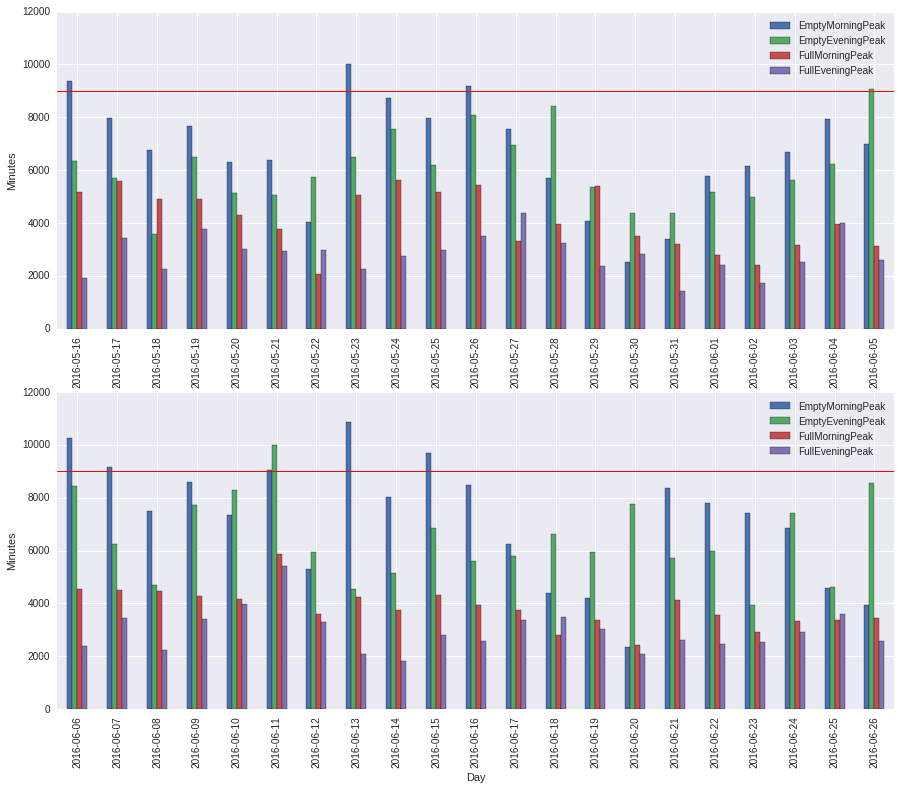

In [91]:
split_idx = len(p1_peak) / 2
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15.0,12.5))  

ax = p2_peak[:split_idx].plot(kind='bar', ax=axes[0])
ax.axhline(y=p2_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')

ax = p2_peak[split_idx:].plot(kind='bar', ax=axes[1])
ax.axhline(y=p2_peak_threshold, linewidth=1, color='r')
ax.set_ylabel('Minutes')

Percentage of days failing to meet the acceptable service levels during peak times for priority 2 docking stations:

In [92]:
failure = pd.concat([empty_p2_morning_peak >= p2_peak_threshold, 
                      empty_p2_evening_peak >= p2_peak_threshold, 
                      full_p2_morning_peak >= p2_peak_threshold, 
                      full_p2_evening_peak >= p2_peak_threshold], axis=1)

failure.columns = ['EmptyMorningPeak', 'EmptyEveningPeak', 'FullMorningPeak', 'FullEveningPeak']

failure.stack().groupby(level=1).aggregate(lambda x: list(x)).apply(lambda x: (float(x.count(True)) / len(x)) * 100)

EmptyEveningPeak     4.761905
EmptyMorningPeak    19.047619
FullEveningPeak      0.000000
FullMorningPeak      0.000000
dtype: float64

The difference in the stations' performance during morning peak hours and evening peak hours is present in priority 2 stations too. However, it is during morning peak hours when the acceptable service level is frequently not met, failing 35.71% of the days, in contrast, 14.28% of the days priority 2 stations did not meet the expected performance level during evening peak hours. 

### PI 26 Maximum Empty Period for a Priority 1 Station

Priority 1 stations should not be empty nor full for more than 30 minutes during peak hours.

In [93]:
max_empty_periods = max_ellapsed_filter(empty_periods)
pi26_results = max_empty_periods.groupby(['Day', 'PeakHours'])['PeriodId'].count()

The plot below shows the number of empty periods of more than 30 minutes during morning and evening peak hours in each day.

#### Empty Stations

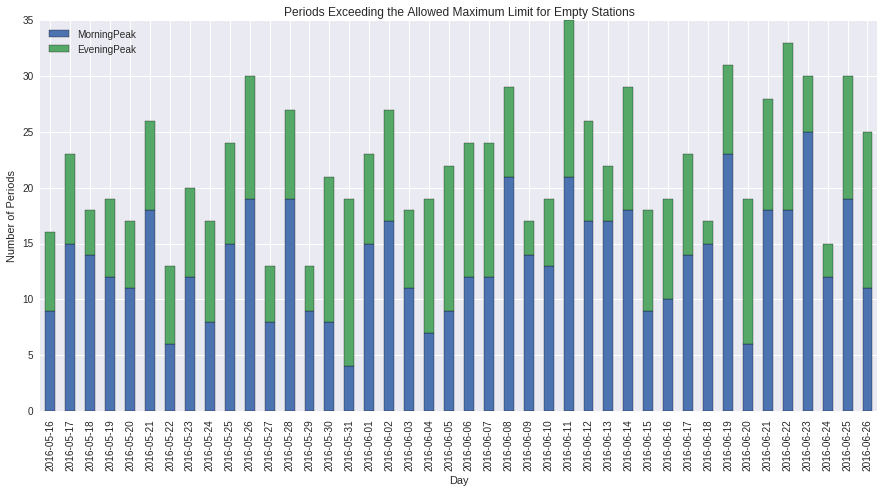

In [94]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7)

empty_max_peak = series_to_df(['MorningPeak', 'EveningPeak'],
                        [pi26_results.xs('MORNING_PEAK', level='PeakHours'), 
                         pi26_results.xs('EVENING_PEAK', level='PeakHours')])

ax = empty_max_peak.plot(kind='bar', stacked=True, title='Periods Exceeding the Allowed Maximum Limit for Empty Stations')
ax.set_ylabel("Number of Periods")

It can be observed that there are more empty periods of more than 30 minutes during the evening peak hours than during the morning peak hours.

In [95]:
max_empty_stations = max_empty_periods.groupby(['Id', 'PeakHours']).count()['PeriodId']
max_empty_evening_stations = max_empty_stations.xs('EVENING_PEAK', level='PeakHours').rename('EveningPeak')
max_empty_morning_stations = max_empty_stations.xs('MORNING_PEAK', level='PeakHours').rename('MorningPeak')

In [96]:
max_empty_stations = pd.concat([max_empty_morning_stations, max_empty_evening_stations], axis=1).reset_index(level=0).fillna(0)
max_empty_stations = max_empty_stations.sort_values(by=['MorningPeak'], ascending=False).rename(columns={'index': 'Id'})
max_empty_stations = add_station_info(max_empty_stations, stations, cols=['Latitude', 'Longitude', 'Id', 'ShortName', 'Name'])

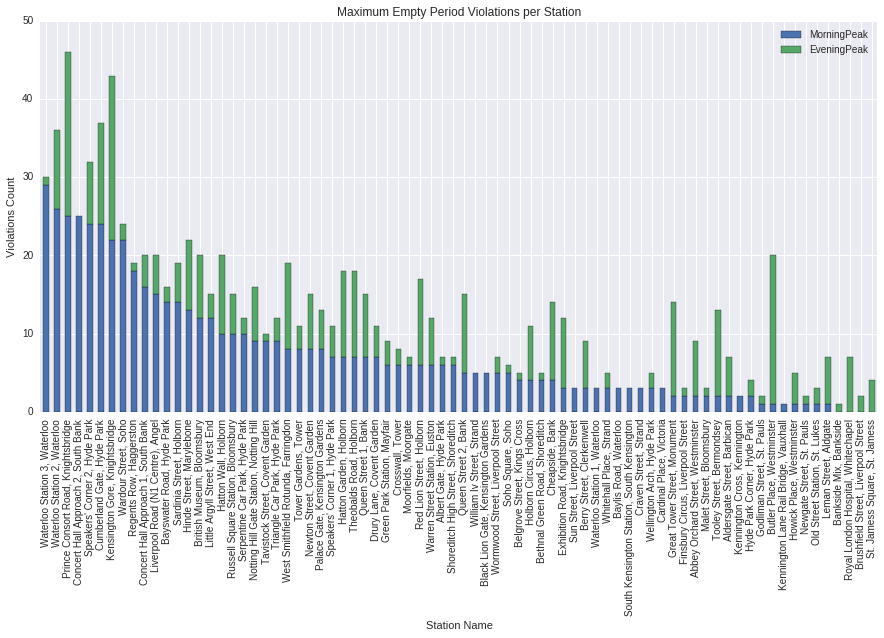

In [97]:
ax = max_empty_stations[['MorningPeak', 'EveningPeak', 'Name']].plot(kind='bar', x='Name', stacked=True,
                                                                   title='Maximum Empty Period Violations per Station')
ax.set(xlabel="Station Name", ylabel="Violations Count")

The plot shows the stations that failed to meet the maximum acceptable empty times for priority 1 stations along with their number of failures. It can be noticed that the stations that fail the PI during the morning peak hours are different than the stations that fail during the evening peak hours.

In [98]:
max_empty_stations['TotalPeak'] = max_empty_stations.MorningPeak + max_empty_stations.EveningPeak

In [99]:
max_empty_stations.TotalPeak.describe()

count    76.000000
mean     12.342105
std       9.798711
min       1.000000
25%       5.000000
50%      11.000000
75%      17.250000
max      46.000000
Name: TotalPeak, dtype: float64

The quartiles show that almost 50% of the acceptable level failures were caused by 25% of the stations. This means that focusing the distribution efforts on these relatively low number of stations could cause up to a 50% increase in the system's performance in PI 26. Further performance increase could be achieved also by focusing on the evening peak time periods. 

In [100]:
peak_diff = max_empty_stations.MorningPeak - max_empty_stations.EveningPeak
normalizer = matplotlib.colors.Normalize(vmin=min(peak_diff) - 0.1,vmax=max(peak_diff) + 0.1)
max_empty_stations['TotalPeakN'] = peak_diff.apply(normalizer)

The map below shows stations that were more mostly empty during morning and evening peak hours in red and blue, respectively. It can be observed that most of the stations that were empty during morning peak hours are in the edge of the city center, while empty stations during evening peak hours are mostly located in the city center. This shows a clear commute usage pattern in the city.

In [118]:
import folium

import matplotlib.pyplot as plt
from src.data.visualization import cmap_to_hex, draw_stations_map

def create_max_empty_marker(station):
    fill_color = cmap_to_hex(plt.get_cmap('seismic'), station.TotalPeakN)
    label = "%s - %s" % (station['Id'], station['Name'])
    
    return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=100,
                        popup=label, fill_color=fill_color, color=fill_color)

maxemptythreshold_stations_map = draw_stations_map(max_empty_stations, create_max_empty_marker)
folium.Map.save(maxemptythreshold_stations_map, 'reports/maps/maxemptythreshold_stations_map.html')
maxemptythreshold_stations_map

### PI 27 Maximum Full Period for a Priority 1 Station

In [103]:
max_full_periods = max_ellapsed_filter(full_periods)
pi27_results = max_full_periods.groupby(['Day', 'PeakHours'])['PeriodId'].count()

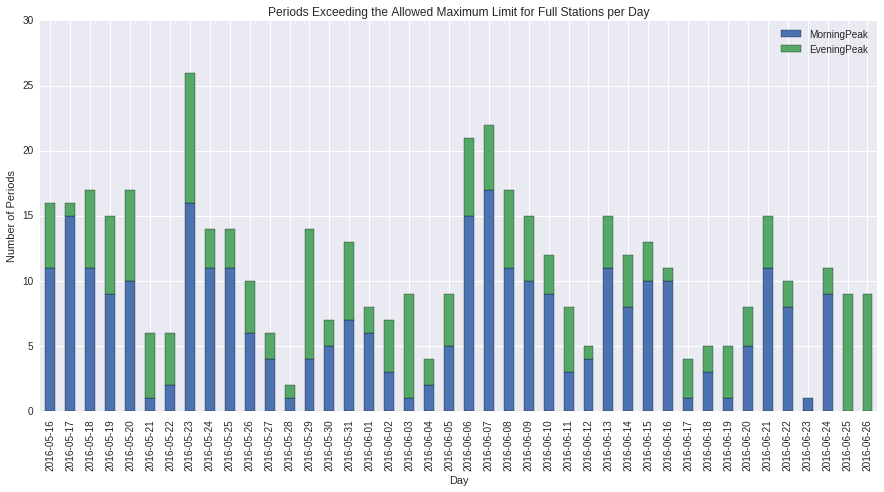

In [104]:
full_max_peak = series_to_df(['MorningPeak', 'EveningPeak'],
                        [pi27_results.xs('MORNING_PEAK', level='PeakHours'), 
                         pi27_results.xs('EVENING_PEAK', level='PeakHours')])
ax = full_max_peak.plot(kind='bar', stacked=True, title='Periods Exceeding the Allowed Maximum Limit for Full Stations per Day')
ax.set_ylabel("Number of Periods")
ax.set_xlabel("Day")

It can be observed that there are more full periods of more than 30 minutes during the morning peak hours than during the evening peak hours.

In [105]:
max_full_stations = max_full_periods.groupby(['Id', 'PeakHours']).count()['PeriodId']
max_full_evening_stations = max_full_stations.xs('EVENING_PEAK', level='PeakHours').rename('EveningPeak')
max_full_morning_stations = max_full_stations.xs('MORNING_PEAK', level='PeakHours').rename('MorningPeak')

In [106]:
max_full_stations = pd.concat([max_full_morning_stations, max_full_evening_stations], axis=1).reset_index(level=0).fillna(0)
max_full_stations = max_full_stations.sort_values(by=['MorningPeak'], ascending=False).rename(columns={'index': 'Id'})
max_full_stations = add_station_info(max_full_stations, stations, cols=['Latitude', 'Longitude', 'Id', 'ShortName', 'Name'])

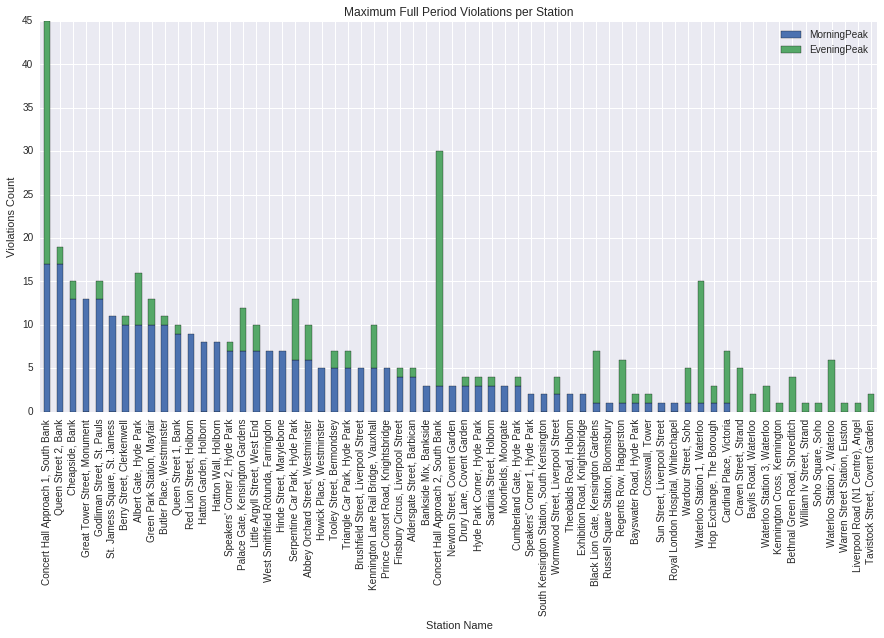

In [107]:
ax = max_full_stations[['MorningPeak', 'EveningPeak', 'Name']].plot(kind='bar', x='Name', stacked=True,
                                                                   title='Maximum Full Period Violations per Station')
ax.set(xlabel="Station Name", ylabel="Violations Count")

In [108]:
max_full_stations['TotalPeak'] = max_full_stations.MorningPeak + max_full_stations.EveningPeak

In [109]:
max_full_stations.TotalPeak.describe()

count    64.000000
mean      7.250000
std       7.195678
min       1.000000
25%       2.750000
50%       5.000000
75%      10.000000
max      45.000000
Name: TotalPeak, dtype: float64

In [112]:
peak_diff = max_full_stations.MorningPeak - max_full_stations.EveningPeak
normalizer = matplotlib.colors.Normalize(vmin=min(peak_diff) - 0.1,vmax=max(peak_diff) + 0.1)
max_full_stations['TotalPeakN'] = peak_diff.apply(normalizer)

In [119]:
maxfullthreshold_stations_map = draw_stations_map(max_full_stations, create_max_empty_marker)
folium.Map.save(maxfullthreshold_stations_map, 'reports/maps/maxfullthreshold_stations_map.html')
maxfullthreshold_stations_map

### Box Plots 

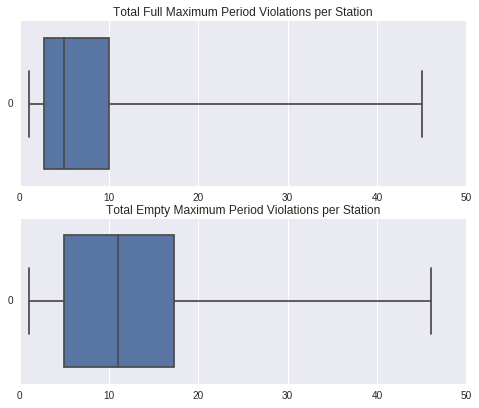

In [187]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8.0,6.5))

ax = sns.boxplot(data=max_full_stations.TotalPeak, whis=10, orient='h', ax=axes[0])
ax.set_title('Total Full Maximum Period Violations per Station')
ax.set_xticks(range(0,60,10))

ax = sns.boxplot(data=max_empty_stations.TotalPeak, whis=10, orient='h', ax=axes[1])
ax.set_title('Total Empty Maximum Period Violations per Station')
ax.set_xticks(range(0,60,10))